# Analysis of Oscillators as Technical Trading Signals

<a href="https://www.kaggle.com/code/addarm/trading-oscillators-quant" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<!-- @import "[TOC]" {cmd="toc" depthFrom=1 depthTo=6 orderedList=false} -->

![MidJourney oscillations, waves and Charts 2023.11.5](https://raw.githubusercontent.com/adamd1985/quant_research/main/images/ocillatorsBanner.png)

Oscillators are momentum indicators used in quantitative trading to identify turning points.

Using moving averages and deviations, these gauge peaks and troughs in momentum. Oscillations above and below ranges or centerlines signal potential overbought or oversold conditions. Divergences between oscillator signals and price can guess probabilistic turning points in asset's trend.

# Common Oscillating Signals

Moving Average Convergence Divergence (MACD) and Absolute Price Oscillator (APO)

These Calculate the difference between two moving averages to identify momentum and trend changes:

* APO is an absolute momentum oscillator while MACD is a relative momentum oscillator. 
* APO identifies trend changes while MACD is looks for gauging acceleration.
* MACD has no fixed center-line and oscillates based on its input data, requiring other signals to synergize with this one.

Relative Strength Index (RSI)  Compares the magnitude of recent gains and losses to identify overbought and oversold conditions:
* Calculates the ratio of higher closing prices vs lower closing prices over a set period. .
* Values under the 30s are usually considered oversold, and over the 70s signal overbought. Both produce a range of 0 to 100.
* Signals divergences from price action usually signal extremes in momentum or reversals.

## Prepare your Environment

Have a jupyter environment ready, and `pip install` these libraries:
- numpy
- pandas
- yfinance


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import dotenv
%load_ext dotenv

import warnings
warnings.filterwarnings("ignore")

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'

if IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle...')
    %pip install yfinance
    %pip install statsmodels
    %pip install seaborn
    %pip install itertools
    %pip install scikit-learn

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print('Running Local...')

import yfinance as yf
from analysis_utils import calculate_profit, load_ticker_ts_df, plot_strategy

Running Local...


In [2]:
tickers = ['AAPL']

START_DATE = '2021-01-01'
END_DATE = '2023-10-31'
APO_BULL_SIGNAL = 5
APO_BEAR_SIGNAL = -5
APO_FAST_WINDOW = 12
APO_SLOW_WINDOW = 45

ticker = load_ticker_ts_df('AAPL', START_DATE, END_DATE)

# The Absolute Price Oscillator (APO)

This technical indicator is made up of a fast moving average and a slow moving average:

1. **Exponential Moving Average (EMA):** A moving average that gives more weight to recent data point:

$$EMA(n) = (Close - EMA(previous, n)) \cdot \frac{2}{n + 1} + EMA(previous, n)$$


2. **fast EMA (fEMA):** Moving Price Average with a 12-day period. Reacts quickly to short-term price changes, sensitive to recent market developments.
3. **slow EMA (sEMA):** Moving Price Average with a 24-day period. Provides a longer-term view of price trends.

The crossover of a fast EMA above a slow EMA can signal a bullish trend, while the opposite can indicate a bearish trend. 

Here is a coded visualization below:

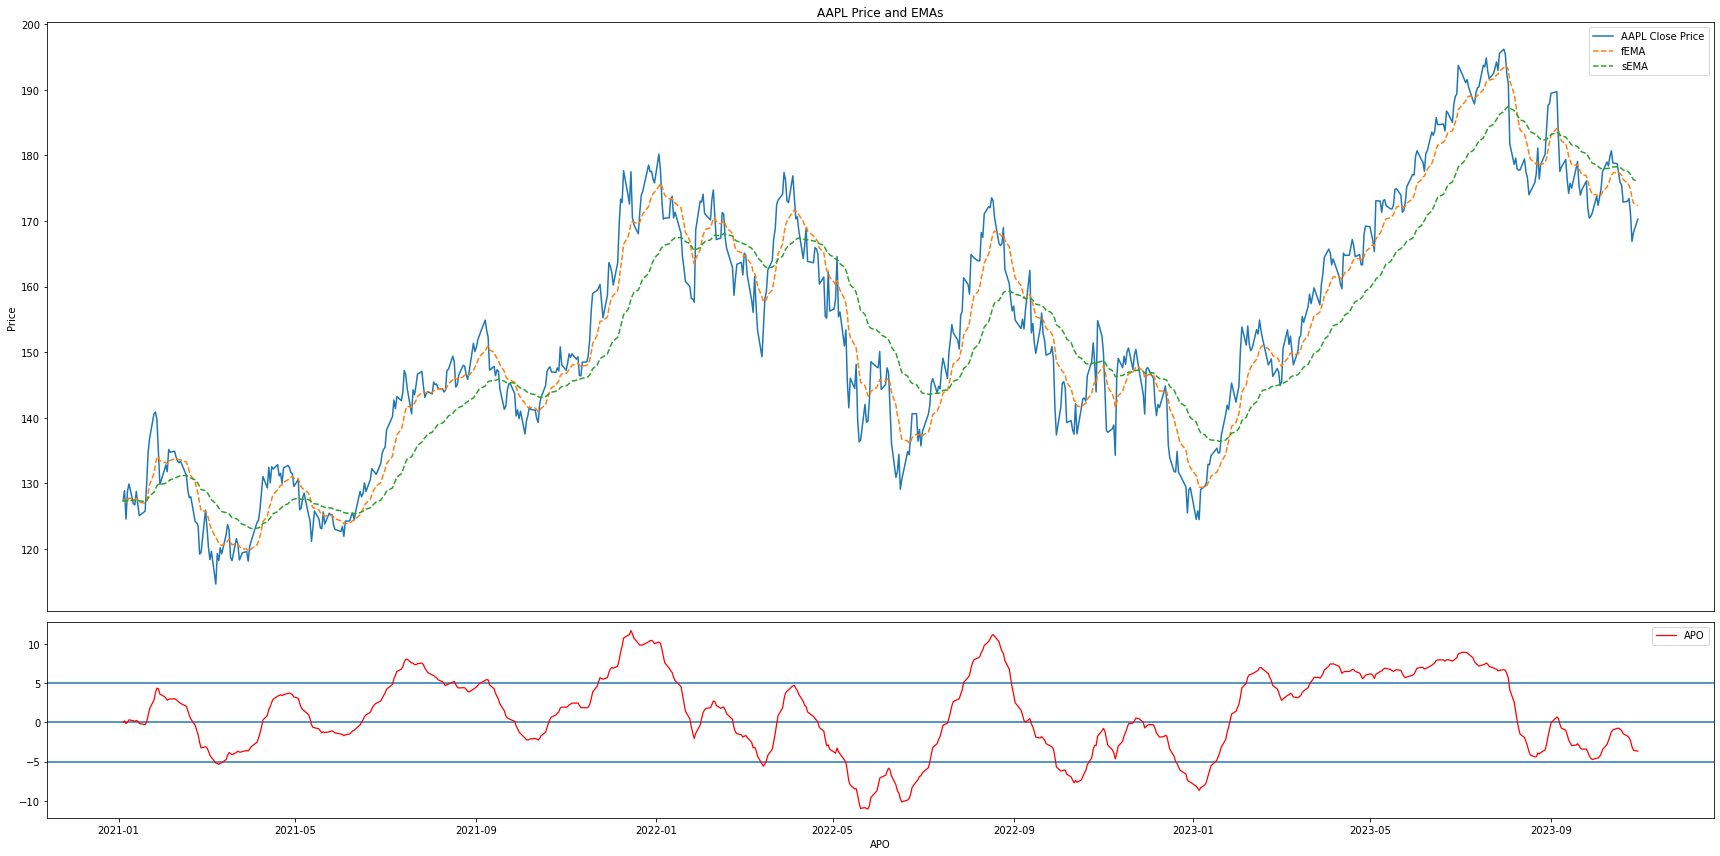

In [3]:
ticker['fEMA'] = ticker['Adj Close'].ewm(
    span=APO_FAST_WINDOW, adjust=False).mean()
ticker['sEMA'] = ticker['Adj Close'].ewm(
    span=APO_SLOW_WINDOW, adjust=False).mean()
ticker['APO'] = ticker['fEMA'] - ticker['sEMA']

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={
    'height_ratios': (3, 1)}, figsize=(24, 12))
ax1.plot(ticker.index, ticker['Adj Close'], label='AAPL Close Price')
ax1.plot(ticker.index, ticker['fEMA'], label='fEMA', linestyle='--')
ax1.plot(ticker.index, ticker['sEMA'], label='sEMA', linestyle='--')
ax1.set_title('AAPL Price and EMAs')
ax1.set_ylabel('Price')
ax1.set_xticks([])

ax2.axhline(APO_BULL_SIGNAL)
ax2.axhline(0.0)
ax2.axhline(APO_BEAR_SIGNAL)
ax2.plot(ticker.index, ticker['APO'], label='APO', lw=1.25, color='r')
ax2.set_xlabel('APO')

ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

With this info, let's build a signal:

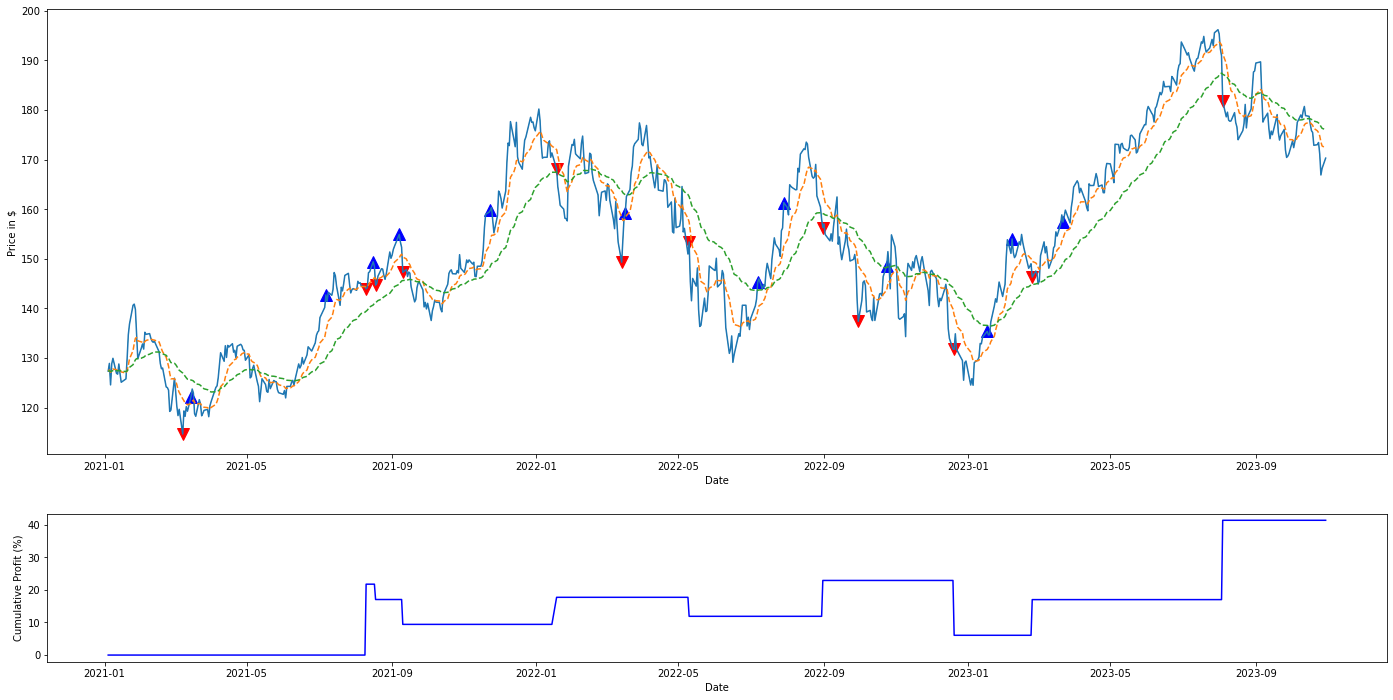

In [4]:
def signal_apo_oscillator(ticker_ts, fast_window_size=APO_FAST_WINDOW, slow_window_size=APO_SLOW_WINDOW, buy_threshold=APO_BULL_SIGNAL, sell_threshold=APO_BEAR_SIGNAL):
    """
    Calculate signals using the Absolute Price Oscillator (APO) indicator for a given stock's time series.
    Parameters:
    - ticker_ts (DataFrame): Time series data for the stock, typically containing 'Adj Close' prices.
    - fast_window_size (int, optional): Fast EMA (Exponential Moving Average) window size. Default is APO_FAST_WINDOW.
    - slow_window_size (int, optional): Slow EMA window size. Default is APO_SLOW_WINDOW.
    - buy_threshold (float, optional): Buy signal threshold for the APO. Default is APO_BULL_SIGNAL.
    - sell_threshold (float, optional): Sell signal threshold for the APO. Default is APO_BEAR_SIGNAL.
    Returns:
    - signals_df (DataFrame): DataFrame containing signals based on APO oscillator:
        - 'signal': Signal values (1 for buy, -1 for sell, 0 for no signal).
        - 'orders': Changes in signals (buy/sell orders) with None for no change.
    """
    fema = ticker_ts['Adj Close'].ewm(
        span=fast_window_size, adjust=False).mean()
    sma = ticker_ts['Adj Close'].ewm(
        span=slow_window_size, adjust=False).mean()
    apo = fema - sma

    signals_df = pd.DataFrame(index=ticker_ts.index)
    signals_df['signal'] = np.where(
        apo >= buy_threshold, 1, np.where(apo <= sell_threshold, -1, 0))
    signals_df['orders'] = signals_df['signal'].diff()
    signals_df.loc[signals_df['orders'] == 0, 'orders'] = None
    return signals_df


signals_df = signal_apo_oscillator(ticker)
profit_series = calculate_profit(signals_df, ticker["Adj Close"])
ax1, ax2 = plot_strategy(ticker["Adj Close"], signals_df, profit_series)
ax1.plot(ticker.index, ticker['Adj Close'], label='AAPL Close Price')
ax1.plot(ticker.index, ticker['fEMA'], label='fEMA', linestyle='--')
ax1.plot(ticker.index, ticker['sEMA'], label='sEMA', linestyle='--')

plt.show()

The strategy generates buy and sell signals based on our threshold values:
`buy_threshold` represents the bullish signal threshold, and `sell_threshold` represents the bearish signal threshold. When our APO crosses any of these thresholds, we will create a signal in the timeseries. 

We'll return a signal dataframe, made up of:
* 'signal': It contains values of 1 (buy), -1 (sell), or 0 (no signal) based on APO conditions.
* 'orders': This column represents changes in trading positions. It is computed as the difference in the 'signal' column and is set to None when no trading position change occurs.

Since all our signals in this series of articles are long only, we will buy on the first buy signal and hold until the first sell signal. That difference is the profit we are charting above. This strategy returned a simulated ~40% in 2 years, against the ~S&P500's 10% - **all on paper**!

# Moving average convergence divergence (MACD)

This fast-food named indicator created by Gerald Appel, goes a step further than the APO.

It establishes the difference between a fast exponential moving average and a slow exponential moving average, like APO, but also smoothens the difference. A properly configured MACD signal **might** capture the direction, magnitude, and duration of a trending instrument price.

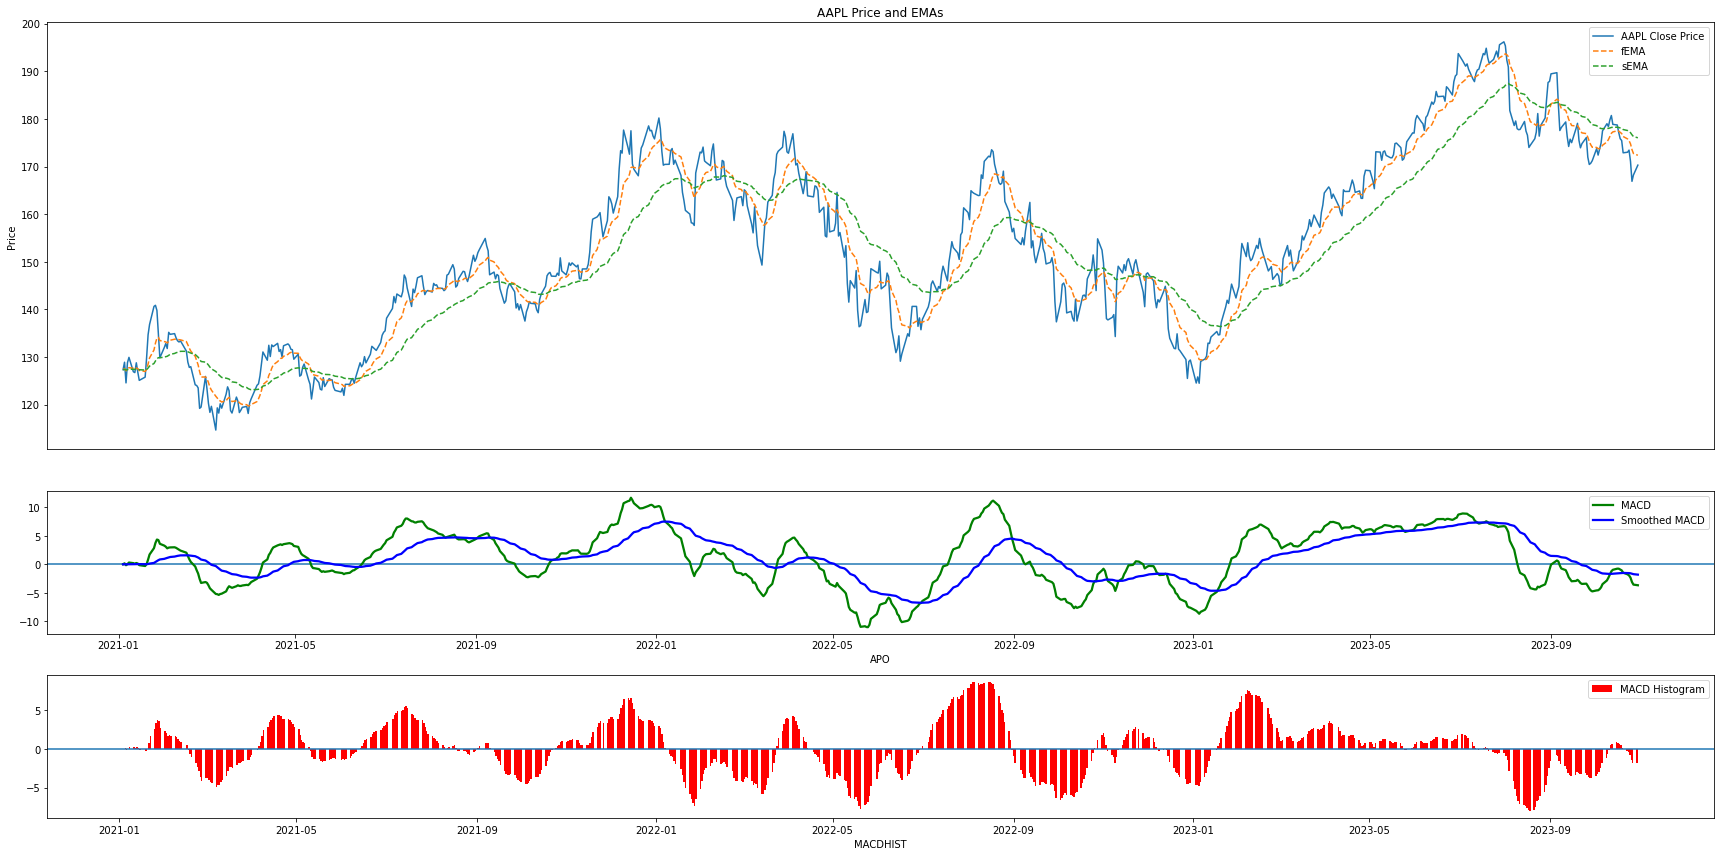

In [5]:
ticker['fEMA'] = ticker['Adj Close'].ewm(
    span=APO_FAST_WINDOW, adjust=False).mean()
ticker['sEMA'] = ticker['Adj Close'].ewm(
    span=APO_SLOW_WINDOW, adjust=False).mean()
ticker['APO'] = ticker['fEMA'] - ticker['sEMA']
ticker['MACD'] = ticker['APO'] .ewm(
    span=APO_SLOW_WINDOW, adjust=False).mean()
ticker['MACDHIST'] = ticker['APO'] - ticker['MACD']

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={
    'height_ratios': (3, 1, 1)}, figsize=(24, 12))
ax1.plot(ticker.index, ticker['Adj Close'], label='AAPL Close Price')
ax1.plot(ticker.index, ticker['fEMA'], label='fEMA', linestyle='--')
ax1.plot(ticker.index, ticker['sEMA'], label='sEMA', linestyle='--')
ax1.set_title('AAPL Price and EMAs')
ax1.set_ylabel('Price')
ax1.set_xticks([])

ax2.axhline(0.0)
ax2.plot(ticker.index, ticker['APO'], label='MACD', lw=2.25, color='g')
ax2.plot(ticker.index, ticker['MACD'],
         label='Smoothed MACD', lw=2.25, color='b')
ax2.set_xlabel('APO')

ax3.axhline(0.0)
ax3.bar(ticker.index, ticker['MACDHIST'],
        label='MACD Histogram', color='r', width=1.0, align='center')
ax3.set_xlabel('MACDHIST')

ax1.legend()
ax2.legend()
ax3.legend()
plt.tight_layout()
plt.show()

For those attentive, MACD is the APO without the threshold lines, and it's its own signal when smoothed.

The **MACD histogram** is another addition to the APO, and captures:
1. Time period when the trend is starting or reversion
2. Magnitude of trends, after reversing signs.

Let's build the signal function:

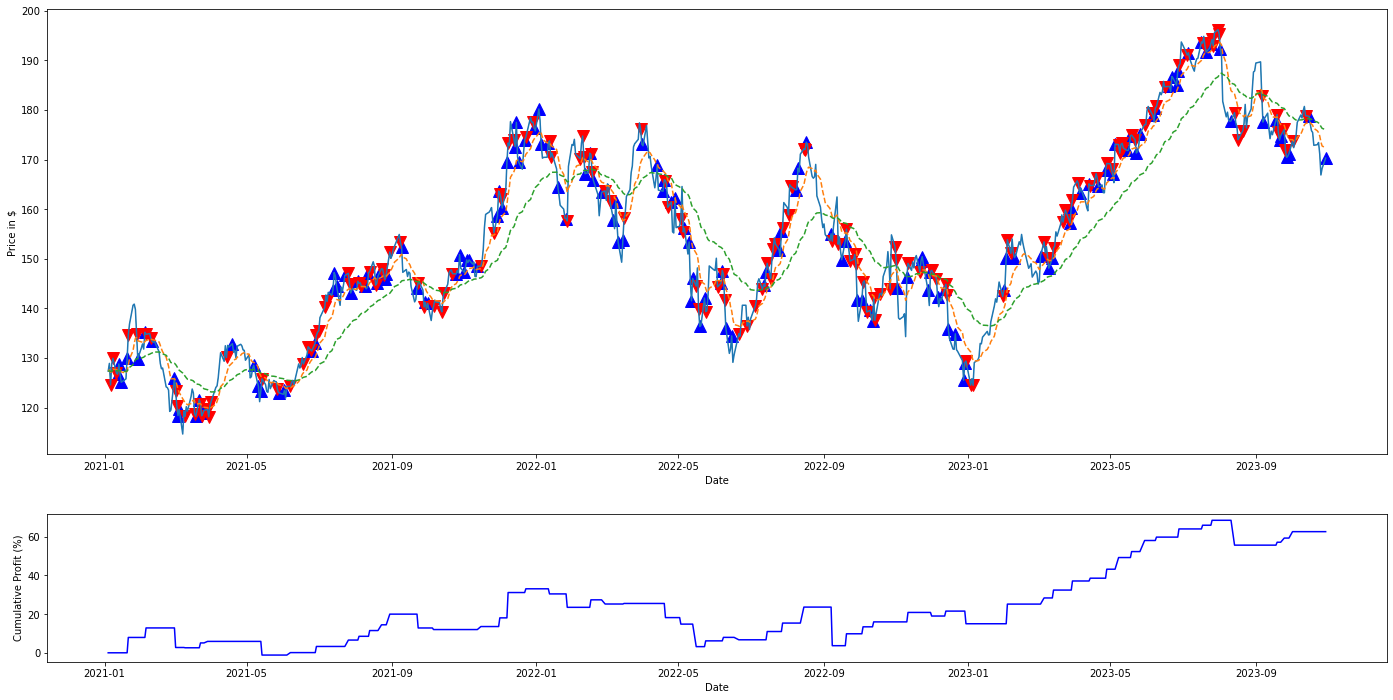

In [6]:
MACD_WINDOW = 9


def signal_macd(ticker_ts, fast_window_size=APO_FAST_WINDOW, slow_window_size=APO_SLOW_WINDOW, signal_window_size=MACD_WINDOW):
    """
    Calculate signals using the MACD (Moving Average Convergence Divergence) indicator for a given stock's time series.
    Parameters:
    - ticker_ts (DataFrame): Time series data for the stock, typically containing 'Adj Close' prices.
    - fast_window_size (int, optional): Fast EMA (Exponential Moving Average) window size. Default is 12.
    - slow_window_size (int, optional): Slow EMA window size. Default is 26.
    - signal_window_size (int, optional): Signal EMA window size. Default is 9.
    Returns:
    - signals_df (DataFrame): DataFrame containing signals based on the MACD oscillator:
        - 'signal': Signal values (1 for buy, -1 for sell, 0 for no signal).
        - 'orders': Changes in signals (buy/sell orders) with None for no change.
    """
    fema = ticker_ts['Adj Close'].ewm(
        span=fast_window_size, adjust=False).mean()
    sma = ticker_ts['Adj Close'].ewm(
        span=slow_window_size, adjust=False).mean()
    macd_line = fema - sma

    # Calculate the Signal Line as a 9-period EMA of the MACD line
    signal_line = macd_line.ewm(span=signal_window_size, adjust=False).mean()

    # Calculate the MACD Histogram as the difference between MACD line and Signal Line
    macd_histogram = macd_line - signal_line

    signals_df = pd.DataFrame(index=ticker_ts.index)
    macd_gradient = macd_histogram.diff()

    # Detect buy (1) and sell (-1) signals based on gradient changes
    buy_signal = (macd_gradient > 0) & (macd_gradient.shift(1) <= 0)
    sell_signal = (macd_gradient < 0) & (macd_gradient.shift(1) >= 0)
    signals_df['signal'] = np.where(
        buy_signal, 1, np.where(sell_signal, -1, 0))
    signals_df['orders'] = signals_df['signal'].diff()
    signals_df.loc[signals_df['orders'] == 0, 'orders'] = None

    return signals_df


signals_df = signal_macd(ticker)
profit_series = calculate_profit(signals_df, ticker["Adj Close"])
ax1, ax2 = plot_strategy(ticker["Adj Close"], signals_df, profit_series)
ax1.plot(ticker.index, ticker['Adj Close'], label='AAPL Close Price')
ax1.plot(ticker.index, ticker['fEMA'], label='fEMA', linestyle='--')
ax1.plot(ticker.index, ticker['sEMA'], label='sEMA', linestyle='--')

plt.show()

Being more advanced than APO because of the strength indicators, let's leverage these shifts in magnitude to signal trades.

The `macd_gradient` is calculated by taking the difference between consecutive MACD Histogram values. This represents the slope or gradient of the histogram.
We signal a buy when the `macd_gradient` turns from negative to positive, we signal a sell when it turns from positive to negative.

Same as the APO above, in the `signal` column 1 represents a buy signal, -1 represents a sell signal, and 0 indicates no signal. We sum all these up for the `orders`. When we calculate the profit, we always find the difference between the first buy and the first sell, as the signal function can generate duplicate signals which, are ignored.

This signal generated 60% returns, **on paper**, but look at all those orders - that would eat away any profits with broker fees!

# Relative Strength Indicator (RSI)

The last indicator in this article. Developed by J. Welles Wilder, the RSI works on price, not price averages, and tracks changes over periods to capture the magnitude of moves.

Using a rolling window, it computes the changes over that period, as well as the magnitude of the averages of losses/price decreases. It then calculates how many more gains relative to the losses, or losses relative to the gains, there has been in a signal from 0 to 100. 
RSI values over 50% indicate an uptrend, while RSI values below 50% indicate a downtrend.

For the last *n* periods, the following applies:

$${RSI} = 100 - \frac{100}{1 + RS}$$

$${RS} = \frac{\text{Average Gain over the last } n \text{ periods}}{\text{Average Loss over the last } n \text{ periods}}$$

Where *Average Gain* is the average of price increases (gains) over the specified period, and *Average Loss* is the average of price decreases over the same period.

* Absolute gain is the `current price - previous price`, IF, `current price > previous price`. The absolute loss here is 0.
* Absolute lost is the `previous price - current price`, IF, `current price < previous price`. The absolute gain here is 0.

Let's visualize this with the AAPL stock:

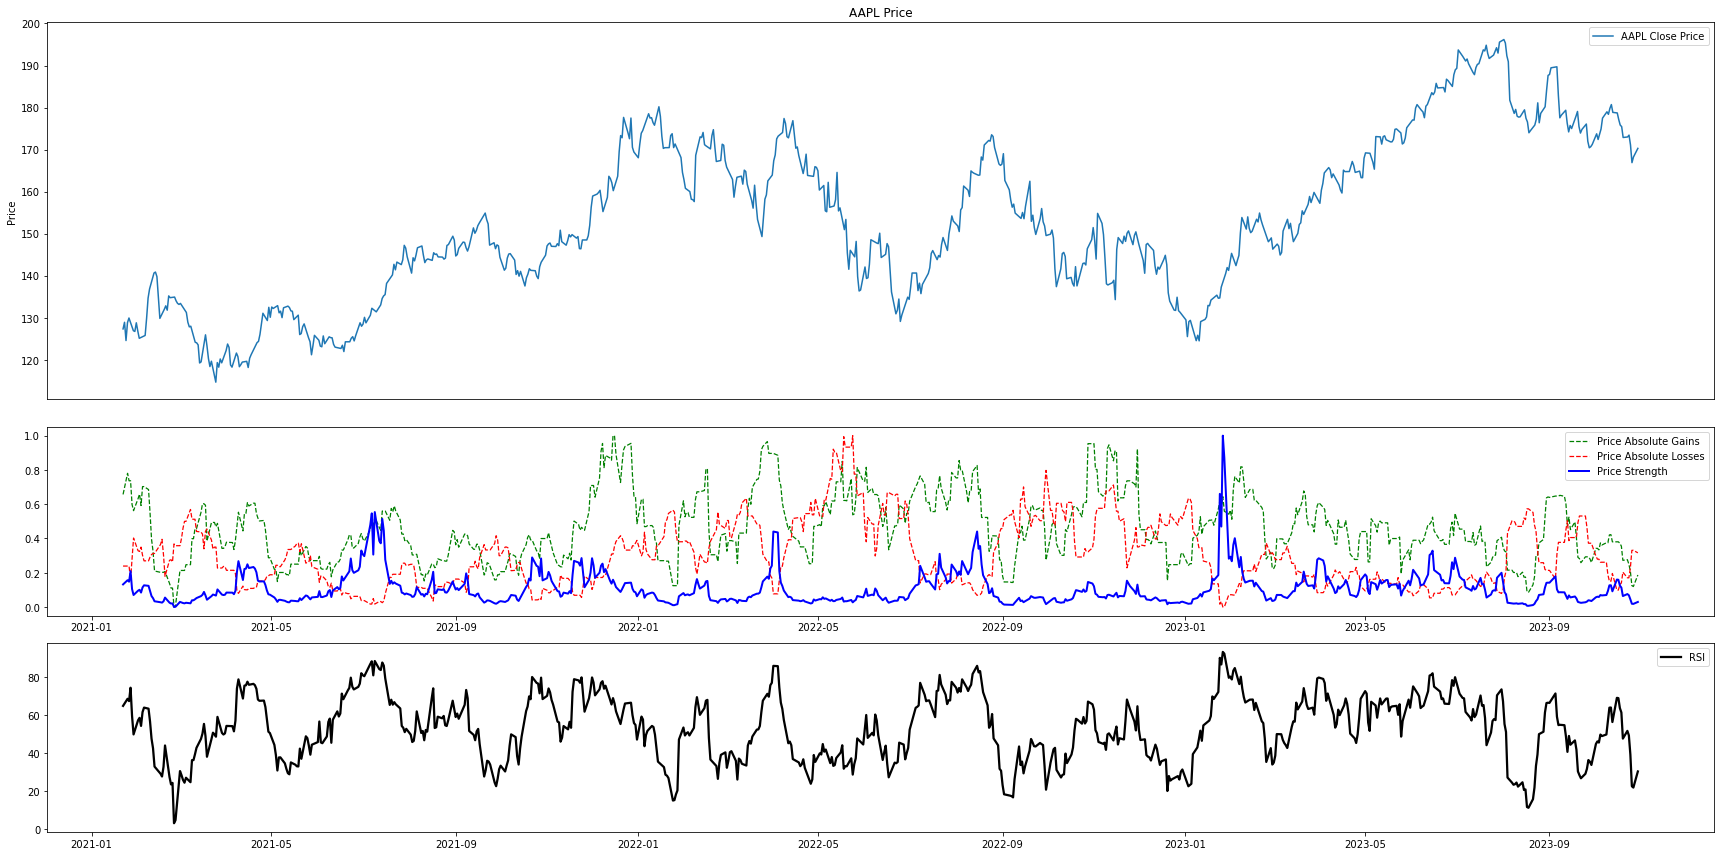

In [7]:
from sklearn.preprocessing import MinMaxScaler

RSI_WINDOW = 14

scaler = MinMaxScaler()

ticker['pDELTA'] = ticker['Adj Close'].diff().fillna(
    0)  # index 0 is NAN in DIFF
ticker['pGAINS'] = ticker['pDELTA'].where(ticker['pDELTA'] > 0, 0)
ticker['pLOSSES'] = -ticker['pDELTA'].where(ticker['pDELTA'] < 0, 0)

ticker['pGAINS'] = ticker['pGAINS'].rolling(
    window=RSI_WINDOW, min_periods=RSI_WINDOW).mean()
ticker['pLOSSES'] = ticker['pLOSSES'].rolling(
    window=RSI_WINDOW, min_periods=RSI_WINDOW).mean()

ticker['RS'] = ticker['pGAINS'] / ticker['pLOSSES']
g_scaled = scaler.fit_transform(ticker['pGAINS'].values.reshape(-1, 1))
l_scaled = scaler.fit_transform(ticker['pLOSSES'].values.reshape(-1, 1))
rs_scaled = scaler.fit_transform(ticker['RS'].values.reshape(-1, 1))
ticker['RSI'] = 100 - (100 / (1 + ticker['RS']))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={
    'height_ratios': (2, 1, 1)}, figsize=(24, 12))
ax1.plot(ticker.index, ticker['Adj Close'], label='AAPL Close Price')
ax1.set_title('AAPL Price')
ax1.set_ylabel('Price')
ax1.set_xticks([])

ax2.plot(ticker.index, g_scaled,
         label='Price Absolute Gains', lw=1.25, color='g', linestyle='--')
ax2.plot(ticker.index, l_scaled,
         label='Price Absolute Losses', lw=1.25, color='r', linestyle='--')
ax2.plot(ticker.index, rs_scaled,
         label='Price Strength', lw=2, color='b')
ax3.plot(ticker.index, ticker['RSI'],
         label='RSI', lw=2.25, color='black')

ax1.legend()
ax2.legend()
ax3.legend()

plt.tight_layout()
plt.show()

We've added a scaler so we can compare the relative strength with the mean absolute gains and losses.

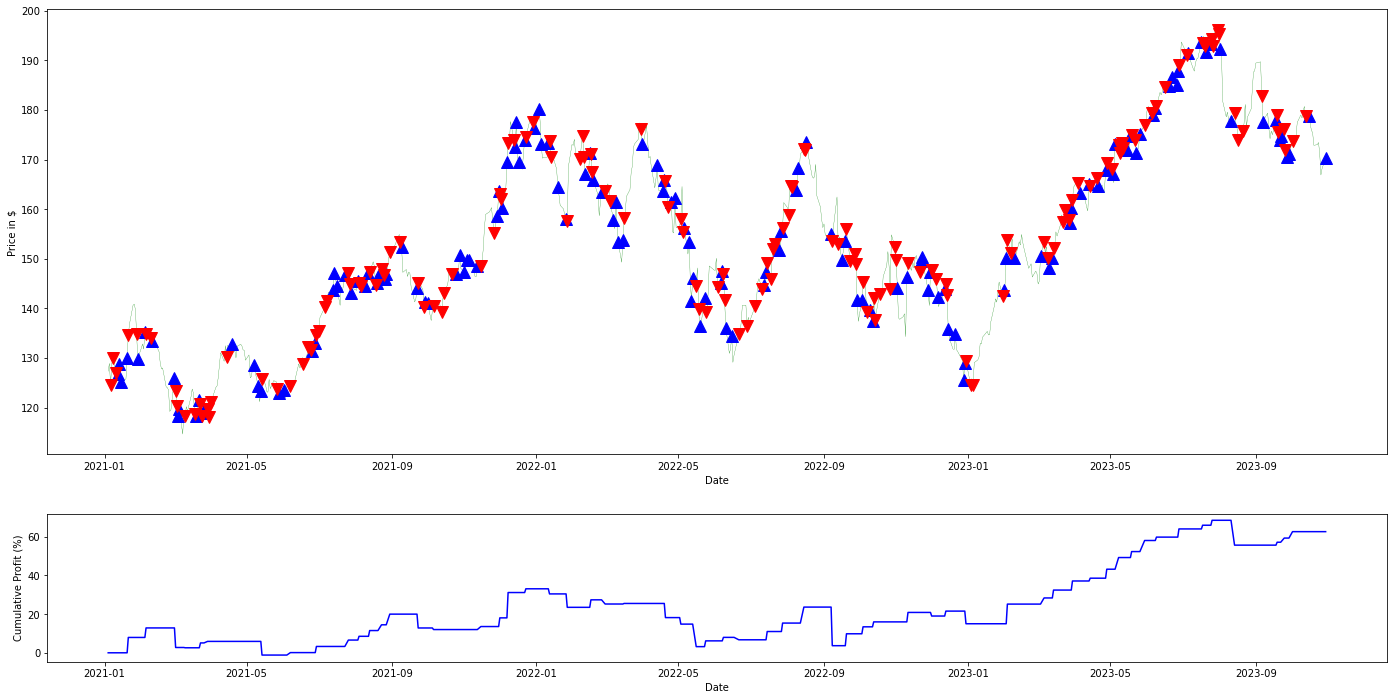

In [8]:
RSI_OVERBOUGH_SIGNAL = 70
RSI_OVERSOLD_SIGNAL = -30


def signal_rsi(ticker_ts, rsi_window=RSI_WINDOW, overbought=RSI_OVERBOUGH_SIGNAL, oversold=RSI_OVERSOLD_SIGNAL):
    """
    Calculate signals using the Relative Strength Index (RSI) indicator for a given stock's time series.
    Parameters:
    - ticker_ts (DataFrame): Time series data for the stock, typically containing 'Close' prices.
    - rsi_window (int, optional): RSI calculation window. Default is 14.
    - overbought (int, optional): RSI threshold for overbought condition. Default is 70.
    - oversold (int, optional): RSI threshold for oversold condition. Default is 30.
    Returns:
    - signals_df (DataFrame): DataFrame containing signals based on the RSI indicator:
        - 'signal': Signal values (1 for buy, -1 for sell, 0 for no signal).
        - 'orders': Changes in signals (buy/sell orders) with None for no change.
    """
    delta = ticker_ts['Close'].diff()

    # Calculate gains (positive changes) and losses (negative changes)
    gains = delta.where(delta > 0, 0)
    losses = -delta.where(delta < 0, 0)

    avg_gains = gains.rolling(window=rsi_window, min_periods=rsi_window).mean()
    avg_losses = losses.rolling(
        window=rsi_window, min_periods=rsi_window).mean()

    rs = avg_gains / avg_losses
    rsi = 100 - (100 / (1 + rs))

    signals_df = pd.DataFrame(index=ticker_ts.index)

    # Detect overbought (1) and oversold (-1) signals based on RSI thresholds
    overbought_signal = rsi > overbought
    oversold_signal = rsi < oversold

    signals_df['signal'] = np.where(
        oversold_signal, 1, np.where(overbought_signal, -1, 0))
    signals_df['orders'] = signals_df['signal'].diff()
    signals_df.loc[signals_df['orders'] == 0, 'orders'] = None

    return signals_df


signals_df = signal_macd(ticker)
profit_series = calculate_profit(signals_df, ticker["Adj Close"])
plot_strategy(ticker["Adj Close"], signals_df, profit_series)
plt.show()

A quantitative trader can use the Relative Strength Index (RSI) to identify overbought and oversold conditions in an asset's price movement:
* When the RSI falls below a certain threshold (e.g., 30), it's considered oversold. There **could be** a reversal to the mean to buy into.
* When the RSI rises above a certain threshold (e.g., 70), it's considered overbought. There **might be** a retraction to a mean, therefore a sell.

This signal returned a **~60% on papers**, we doing something good here or we have an error we aren't seeing! It also created many orders and therefore fees, which would have ate into the profits.

# Conclusion

To conclude, with a simulation using Apple's stock, we learned how quants would implement these oscillator signals, and how **EMAs** help filter out noise in a dataset for a clearer picture on trends.

Now, A quant might use these signals to catch inflections in the asset's trend and help to gauge closing momentum or if its due for a pullback. Your Youtube fin-crowd would use it to sell you trading courses, stay safe.


![MidJourney A sad finfluencecr looking at waves 2023.11.5](https://raw.githubusercontent.com/adamd1985/quant_research/main/images/traderLookingAtWaves.png)

## References

- https://www.linkedin.com/pulse/pairs-trading-strategy-every-stock-needs-friend-adam-darmanin-489ff/
- https://www.linkedin.com/pulse/momentum-reversion-poor-mans-trading-strategies-adam-darmanin-vhrif/
- https://www.investopedia.com/terms/o/oscillator.asp
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html 

## Github

Article here is also available on [Github](https://github.com/adamd1985/quant_research/blob/main/oscilators-quant.ipynb)

Kaggle notebook available [here](https://www.kaggle.com/code/addarm/trading-oscillators-quant)


## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.